In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestRegressor

import scipy
from scipy import stats
import math
import pickle

from sqlalchemy import create_engine


# Preparing training set to pass to model

In [2]:
username = "DublinBikesApp"
password = "dublinbikesapp"
endpoint = "dublinbikesapp.cynvsd3ef0ri.us-east-1.rds.amazonaws.com"
port = "3306"
db = "DublinBikesApp"

engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(username, password, endpoint, port, db), echo=True)

In [3]:
#prediction for station number n
#station_id= 3

sql =  f"""
SELECT * FROM DublinBikesApp.dynamicData
where mod(Insert_ID, 6) = 0
group by last_update
order by number, last_update asc;
"""

sql_weather =  f"""
SELECT DISTINCT weather FROM forecast;
"""

In [4]:
#look in forecast for weather event not met yet in historical data
df_weather = pd.read_sql_query(sql_weather, engine)
events_forecast=df_weather['weather'].values.tolist()
list_forecast=['month', 'day', 'hour', 'temp']
for event in events_forecast:
    list_forecast.append('weather_'+event)

#creating dataframe for all existing stations
df= pd.read_sql_query(sql, engine)


2021-04-14 10:45:14,109 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-04-14 10:45:14,110 INFO sqlalchemy.engine.base.Engine {}
2021-04-14 10:45:14,394 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-04-14 10:45:14,395 INFO sqlalchemy.engine.base.Engine {}
2021-04-14 10:45:14,928 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-04-14 10:45:14,929 INFO sqlalchemy.engine.base.Engine {}
2021-04-14 10:45:15,466 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-04-14 10:45:15,467 INFO sqlalchemy.engine.base.Engine {}
2021-04-14 10:45:15,750 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-04-14 10:45:15,751 INFO sqlalchemy.engine.base.Engine {}
2021-04-14 10:45:16,107 INFO sqlalchemy.engine.base.OptionEngine 
SELECT DISTINCT weather FROM forecast;

2021-04-14 10:45:16,108 INFO sqlalchemy.engine.base.OptionEngine {}
2021-04-14 10

In [5]:
#clean and align features
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace(' ', '_')
print(df.shape)

(174341, 8)


In [6]:
#split last_update to day, hour, month for df and drop last_update
df["day"] = df["last_update"].dt.dayofweek
df["hour"] = df["last_update"].dt.hour
df["month"] = df["last_update"].dt.month
df=df.drop(["last_update"], axis=1)
df

,Insert_ID,number,bike_stands,available_bike_stands,available_bikes,weather,temp,day,hour,month
0,0,2,20,15,5,Fog,2.90,0,1,3
1,6,2,20,15,5,Fog,2.91,0,1,3
2,12,2,20,15,5,Fog,2.54,0,2,3
3,18,2,20,15,5,Fog,2.50,0,2,3
4,24,2,20,15,5,Fog,2.74,0,3,3
...,...,...,...,...,...,...,...,...,...,...
174336,7740,507,1,0,1,Clouds,10.49,6,0,3
174337,7884,507,1,0,1,Clouds,14.69,6,12,3
174338,7890,507,1,1,0,Clouds,14.29,6,12,3
174339,7896,507,1,0,1,Clouds,14.71,6,13,3


In [7]:
#for historical data df only, move available_bikes to target position for training set
cols = list(df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('available_bikes')) #Remove available from index
df = df[cols+['available_bikes']] #Create new dataframe with columns in the order you want
df

,Insert_ID,number,bike_stands,available_bike_stands,weather,temp,day,hour,month,available_bikes
0,0,2,20,15,Fog,2.90,0,1,3,5
1,6,2,20,15,Fog,2.91,0,1,3,5
2,12,2,20,15,Fog,2.54,0,2,3,5
3,18,2,20,15,Fog,2.50,0,2,3,5
4,24,2,20,15,Fog,2.74,0,3,3,5
...,...,...,...,...,...,...,...,...,...,...
174336,7740,507,1,0,Clouds,10.49,6,0,3,1
174337,7884,507,1,0,Clouds,14.69,6,12,3,1
174338,7890,507,1,1,Clouds,14.29,6,12,3,0
174339,7896,507,1,0,Clouds,14.71,6,13,3,1


In [8]:
#change month, day, hour, weather to category type
for col in ['month','day','hour','weather']:
    df[col] = df[col].astype("category")

# Modelling and serializing

In [9]:
list_stations=df.number.unique().tolist()
#model_station=[]
for station in list_stations:
    model_station="model_station_"+str(station)
    #print(model_station)
    df_s=df[df['number']==station]
    X_train,X_test,y_train,y_test=train_test_split(df_s.iloc[:,0:-1],df_s.iloc[:,-1],test_size=0.3, random_state=42)
    X_train.reset_index(inplace=True)
    y_train=y_train.reset_index()

    # Reset train index values
    X_test.reset_index(inplace=True)
    y_test=y_test.reset_index()
    #Create a new dataset for train attributes
    train_attributes=X_train[['month','day','hour','weather','temp']]
    #Create a new dataset for test attributes
    test_attributes=X_test[['month','day','hour','weather','temp']]
    #categorical attributes
    cat_attributes=['weather']
    #numerical attributes
    num_attributes=['month','day','hour','temp']
    
    #To get dummy variables to encode the categorical features to numeric
    #Decoding the training attributes
    train_encoded_attributes=pd.get_dummies(train_attributes,columns=cat_attributes)
    #list all features to compare with potential new events in forecast
    list_features=list(train_encoded_attributes.columns)
    #print(list_features)
    #print('Shape of transfomed dataframe::',train_encoded_attributes.shape)
    #train_encoded_attributes.head(5)
    
    #Decoding the test attributes
    test_encoded_attributes=pd.get_dummies(test_attributes,columns=cat_attributes)
    #print('Shape of transformed dataframe :',test_encoded_attributes.shape)
    #test_encoded_attributes.head(5)
    
    #synchronize features from forecast to historical data
    for feat in list_forecast:
        if feat not in list_features:
            train_encoded_attributes[feat] = 0
            test_encoded_attributes[feat] = 0

    features_check=[test_encoded_attributes,train_encoded_attributes]       
    
    if all(v.shape[1] != test_encoded_attributes.shape[1] for v in features_check):
        print('Features not aligned')
    
    #if all(v.shape[1] == test_encoded_attributes.shape[1] for v in features_check):
        #print('All features aligned ({})'.format(test_encoded_attributes.shape[1]))
    #else:
        #print('Features not aligned')
        
    X_train=train_encoded_attributes
    y_train=y_train.available_bikes.values
    
    #Test dataset
    X_test=test_encoded_attributes
    y_test=y_test.available_bikes.values
    
    
    rf=RandomForestRegressor(n_estimators=100)
    rf.fit(X_train,y_train)

    with open(model_station,'wb') as handle:
        pickle.dump(rf,handle,pickle.HIGHEST_PROTOCOL)

# Testing on specific station

In [10]:
station=4
sel=df.loc[df['number'] == station]
sel

,Insert_ID,number,bike_stands,available_bike_stands,weather,temp,day,hour,month,available_bikes
4023,0,4,20,17,Fog,2.90,0,1,3,3
4024,6,4,20,17,Fog,2.91,0,1,3,3
4025,12,4,20,17,Fog,2.54,0,2,3,3
4026,18,4,20,17,Fog,2.50,0,2,3,3
4027,24,4,20,17,Fog,2.74,0,3,3,3
...,...,...,...,...,...,...,...,...,...,...
5970,12228,4,20,14,Clouds,7.39,0,15,4,6
5971,12234,4,20,15,Rain,7.49,0,15,4,5
5972,12240,4,20,16,Clouds,7.20,0,16,4,4
5973,12246,4,20,17,Rain,7.29,0,16,4,3


In [11]:



#Split the dataset into the train and test data
X_train,X_test,y_train,y_test=train_test_split(sel.iloc[:,0:-1],sel.iloc[:,-1],test_size=0.3, random_state=42)

#Reset train index values
X_train.reset_index(inplace=True)
y_train=y_train.reset_index()

# Reset train index values
X_test.reset_index(inplace=True)
y_test=y_test.reset_index()

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
print(y_train.head())
print(y_test.head())

(1366, 10) (586, 10) (1366, 2) (586, 2)
   index  available_bikes
0   4878               10
1   5968                8
2   5036                5
3   5703                7
4   5643               11
   index  available_bikes
0   5638               11
1   5429                7
2   5929               14
3   5603                8
4   4330                0


In [12]:
#Create a new dataset for train attributes
train_attributes=X_train[['month','day','hour','weather','temp']]
#Create a new dataset for test attributes
test_attributes=X_test[['month','day','hour','weather','temp']]
#numerical attributes
cat_attributes=['weather']
#categorical attributes
num_attributes=['month','day','hour','temp']

In [13]:
#To get dummy variables to encode the categorical features to numeric
#Decoding the training attributes
train_encoded_attributes=pd.get_dummies(train_attributes,columns=cat_attributes)
#list all features to compare with potential new events in forecast
list_features=list(train_encoded_attributes.columns)
print(list_features)
#print('Shape of transfomed dataframe::',train_encoded_attributes.shape)
#train_encoded_attributes.head(5)

['month', 'day', 'hour', 'temp', 'weather_Clear', 'weather_Clouds', 'weather_Drizzle', 'weather_Fog', 'weather_Mist', 'weather_Rain', 'weather_Snow']


In [14]:
#Decoding the test attributes
test_encoded_attributes=pd.get_dummies(test_attributes,columns=cat_attributes)
print('Shape of transformed dataframe :',test_encoded_attributes.shape)
test_encoded_attributes.head(5)

Shape of transformed dataframe : (586, 11)


,month,day,hour,temp,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Mist,weather_Rain,weather_Snow
0,4,0,14,6.17,0,1,0,0,0,0,0
1,4,3,4,8.09,0,1,0,0,0,0,0
2,4,6,17,6.77,0,0,0,0,0,1,0
3,4,6,20,8.82,0,1,0,0,0,0,0
4,3,6,11,7.44,0,1,0,0,0,0,0


In [15]:
#synchronize features from forecast to historical data
for feat in list_forecast:
    if feat not in list_features:
        train_encoded_attributes[feat] = 0
        test_encoded_attributes[feat] = 0

features_check=[test_encoded_attributes,train_encoded_attributes]       

if all(v.shape[1] == test_encoded_attributes.shape[1] for v in features_check):
    print('All features aligned ({})'.format(test_encoded_attributes.shape[1]))
else:
    print('Features not aligned')
    
#print('Shape of transfomed dataframe:',prediction_encoded_attributes.shape[1])
print('Shape of transfomed dataframe:',test_encoded_attributes.shape)
print('Shape of transfomed dataframe:',train_encoded_attributes.shape)

All features aligned (11)
Shape of transfomed dataframe: (586, 11)
Shape of transfomed dataframe: (1366, 11)


In [16]:
#Training dataset for modelling
X_train=train_encoded_attributes
y_train=y_train.available_bikes.values

In [17]:
#Test dataset
X_test=test_encoded_attributes
y_test=y_test.available_bikes.values
X_train

,month,day,hour,temp,weather_Clear,weather_Clouds,weather_Drizzle,weather_Fog,weather_Mist,weather_Rain,weather_Snow
0,3,4,12,10.08,0,1,0,0,0,0,0
1,4,0,14,8.01,0,1,0,0,0,0,0
2,3,0,20,8.67,0,1,0,0,0,0,0
3,4,1,22,2.53,0,1,0,0,0,0,0
4,4,0,16,5.27,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1361,3,3,9,9.51,0,1,0,0,0,0,0
1362,3,0,17,15.88,0,1,0,0,0,0,0
1363,3,4,14,11.40,0,1,0,0,0,0,0
1364,4,4,7,5.77,0,1,0,0,0,0,0


## Random Forest

In [18]:
#Training the model
X_train=train_encoded_attributes
rf=RandomForestRegressor(n_estimators=200)

In [19]:
#Fit the trained model
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200)

In [20]:
#accuracy of the model
rf_score =rf.score(X_train,y_train)
print('Accuracy of the model :',rf_score)

Accuracy of the model : 0.9541226192766206


In [21]:
#Cross validation prediction
predict=cross_val_predict(rf,X_train,y_train,cv=3)
predict

array([9.465     , 4.8625    , 4.86192857, ..., 7.33      , 7.31      ,
       9.385     ])

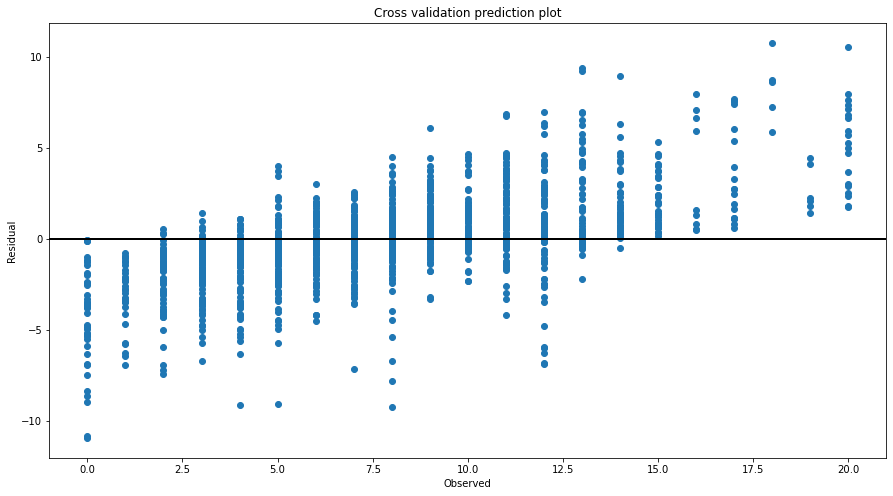

In [22]:
#Cross validation prediction plot
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [23]:
#R-squared scores
r2_scores = cross_val_score(rf, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.6349126099796918


### Random Forest Model performance on test dataset

In [24]:
#predict the model
X_test=test_encoded_attributes
print(X_test)
rf_pred=rf.predict(X_test)
rf_pred

    month day hour   temp  weather_Clear  weather_Clouds  weather_Drizzle  \
0       4   0   14   6.17              0               1                0   
1       4   3    4   8.09              0               1                0   
2       4   6   17   6.77              0               0                0   
3       4   6   20   8.82              0               1                0   
4       3   6   11   7.44              0               1                0   
..    ...  ..  ...    ...            ...             ...              ...   
581     4   3   19   8.34              0               1                0   
582     4   6    5   2.09              0               1                0   
583     4   0    6   3.73              0               1                0   
584     3   4   20   3.05              0               1                0   
585     3   2   13  12.02              0               1                0   

     weather_Fog  weather_Mist  weather_Rain  weather_Snow  
0             

array([10.265     ,  5.975     , 12.72      ,  7.63      ,  5.04      ,
        4.745     ,  7.28      ,  3.855     , 13.04      ,  5.545     ,
        6.265     ,  9.105     ,  9.665     ,  5.575     ,  9.51      ,
        2.39      , 11.35      ,  2.86      ,  8.535     ,  3.065     ,
       13.89      ,  9.        ,  4.18      ,  3.10833333, 13.535     ,
        8.535     ,  4.24966667, 13.325     ,  3.04583333,  4.205     ,
       10.17      ,  5.62      , 11.995     ,  9.92      ,  9.425     ,
        9.        , 10.645     ,  5.06680952,  6.565     ,  6.65833333,
       11.11333333,  7.41625   , 11.10166667,  6.94      ,  4.755     ,
        7.425     ,  8.59625   ,  8.9       ,  6.555     , 13.89235714,
        4.09083333,  6.95791667,  5.34      ,  7.55916667,  8.1       ,
        5.925     ,  5.355     ,  4.145     ,  4.635     ,  6.555     ,
        8.185     , 10.505     , 11.875     ,  5.6825    ,  6.05      ,
        7.71791667, 10.375     ,  2.54      ,  7.98      ,  4.40

In [25]:
print(y_test)
print(rf_pred)

[11  7 14  8  0  5  3  3 15  4  5 10  7  7 11  0 11  2  6  3 16  9  7  3
 13  7  4 17  2  4 11  8 12 10  9  9 14  4  9  7  9  0 11 10  7  8  8 10
  6 13  8  7  1  9 12  5  4  4  3  7  9 12 12  3  4  9 13  2  8  8  4  0
 11 13  0 14  7  7  4  6  2  4  2  0  9 10 17  7  3 13 12  6  8 12 11  8
  1 13  5  2  4 14 11 11  7 12  2 20  8 19 20  8  6 12 10 15 11  6  4 16
 12 11  9  9  7 10  0 12  7 14  9  6 17 12  2  7  5  5 15  5  4  4 14  8
  4  8  1  2  2  1  4  7  4  9  8  0 14  6  4  3  6  6  7  4 11 11  2  1
  7 20  8  7  0 12  9  7 12 14 13  7 11 14  8  4  6 10  9  8 10  8 20 11
  5 12  4  3  4 11 12 15 19 11  3  4 12  7  5 12  7  4  9  0  4  8  7 12
 13  2  7  0 10  3  9  3 11  5 12  9  5 13 19  5  6  4 10 12  4  9  9  7
  0  2  4  5 17 11  9  2 12 10 13  6  3 17  9  5  8  6  0  6 10  9 15  0
  4  7  9  3  4 10  9 13 10 11  5 11  5  7 18  9  3  9  7  6 15  4  9  4
 12  4  7  4  7  8  7  7 12 11  3  7 10  4 10  5  4 14  5 13  8  1  6  8
 13  6 11 11  9 13  4 20  4 12  2  7  0 19  9  6  5

In [26]:
#Root mean square error
rmse = math.sqrt(metrics.mean_squared_error(y_test,rf_pred))
print('Root mean square error :',rmse)
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,rf_pred)
print('Mean absolute error :',mae)

Root mean square error : 2.3909966790507395
Mean absolute error : 1.614163456850317


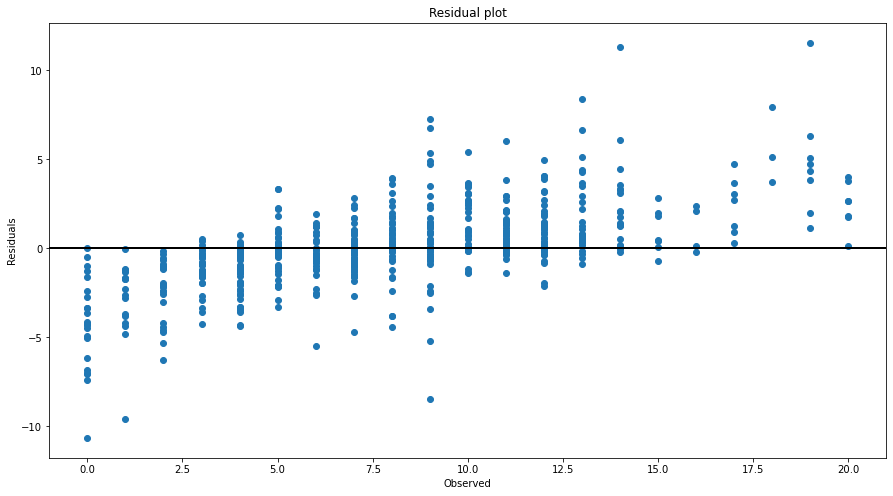

In [27]:
fig, ax = plt.subplots(figsize=(15,8))
residuals=y_test-rf_pred
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.set_title('Residual plot')
plt.show()

In [28]:
Bike_df1=pd.DataFrame(y_test,columns=['y_test'])
Bike_df2=pd.DataFrame(rf_pred,columns=['rf_pred'])
Bike_predictions=pd.merge(Bike_df1,Bike_df2,left_index=True,right_index=True)
Bike_predictions.to_csv('Bike_Renting_Python.csv')
Bike_predictions


,y_test,rf_pred
0,11,10.265000
1,7,5.975000
2,14,12.720000
3,8,7.630000
4,0,5.040000
...,...,...
581,5,5.029167
582,7,6.782500
583,19,12.675000
584,7,6.100000
